<a href="https://colab.research.google.com/github/AndrewPolyak/PyTorch-Self-Learning/blob/main/PyG/EpiLearn/EpiLearn_Pipeline_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Install and Import Dependencies

* `torch_scatter`, `torch_geometric`, and `epilearn` must be installed via pip.

* `torch`, `torch_geometric`, and `epilearn` are imported for deep learning.

* `numpy` and `pandas` are imported for data handling.



In [1]:
!pip install torch_scatter
!pip install torch_geometric
!pip install epilearn

In [2]:
import torch
import torch_geometric
import epilearn

import numpy as np
import pandas as pd

# 2 Download and Pre-Process Dataset

This mini-project leverages an open-access set of time-series CSV files noting cases and deaths on a per-day basis across most countries.

The population for each country is also accessed as a CSV.

The noted data is loaded into DataFrames and is processed to a tensor of shape `time_steps, num_nodes, num_features` where a single time step is a day, a single node is a country, and there are 3 features (susceptible, infected, recovered) (i.e., SIR).

## 2.1 Load Susceptible, Infected, and Recovered CSVs Into DataFrames

In [3]:
# Define URLs for CSVs
population_csv_url = "https://ourworldindata.org/grapher/population.csv?v=1&csvType=full&useColumnShortNames=true"
infected_csv_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_csv_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [4]:
# Load population csv
population_df = pd.read_csv(population_csv_url,
                            storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Extract only year 2020 for each nation (for simplicity)
population_df = population_df[population_df["Year"] == 2020]

# Drop 'Code' and 'Year' columns
population_df = population_df.drop(columns=["Code", "Year"])

# Rename 'Entity' to 'Country/Region' and 'population_historical' to 'Population'
population_df = population_df.rename(columns={"Entity": "Country/Region", "population_historical": "Population"})

population_df.head(5)

,Country/Region,Population
257,Afghanistan,39068933
522,Africa,1380818597
596,Africa (UN),1380821116
860,Albania,2871900
1121,Algeria,44042041


In [5]:
# Load infected csv
infected_df = pd.read_csv(infected_csv_url)

# Drop 'Province/State', 'Lat', 'Long' Columns for Simplicity
infected_df = infected_df.drop(columns=["Province/State", "Lat", "Long"])

infected_df.head(5)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,Albania,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,Algeria,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,Andorra,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,Angola,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [6]:
# Load recovered csv
recovered_df = pd.read_csv(recovered_csv_url)

# Drop 'Province/State', 'Lat', 'Long' Columns for Simplicity
recovered_df = recovered_df.drop(columns=["Province/State", "Lat", "Long"])

recovered_df.head(5)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albania,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Algeria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Andorra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Angola,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.2 Configure and Clean DataFrames

Remove duplicates and ensure each DataFrame has matching / corresponding values.

In [7]:
# Remove duplicates
print(f"Length of 'population_df' before: {len(population_df)}")
population_df = population_df.drop_duplicates(subset="Country/Region")
print(f"Length of 'population_df' after: {len(population_df)}\n")

print(f"Length of 'infected_df' before: {len(infected_df)}")
infected_df = infected_df.drop_duplicates(subset="Country/Region")
print(f"Length of 'infected_df' after: {len(infected_df)}\n")

print(f"Length of 'recovered_df' before: {len(recovered_df)}")
recovered_df = recovered_df.drop_duplicates(subset="Country/Region")
print(f"Length of 'recovered_df' after: {len(recovered_df)}")

Length of 'population_df' before: 260
Length of 'population_df' after: 260

Length of 'infected_df' before: 289
Length of 'infected_df' after: 201

Length of 'recovered_df' before: 274
Length of 'recovered_df' after: 201


In [8]:
# Inner join DataFrames to ensure countries match
temp_df = pd.merge(infected_df, population_df, how="inner", on="Country/Region")
temp_df = temp_df.merge(recovered_df, how="inner", on="Country/Region") # Dates for recovered are denoted with 'y' prefix

temp_df.head(3)

,Country/Region,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,1/29/20_x,1/30/20_x,...,2/28/23_y,3/1/23_y,3/2/23_y,3/3/23_y,3/4/23_y,3/5/23_y,3/6/23_y,3/7/23_y,3/8/23_y,3/9/23_y
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albania,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Algeria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(f"Number of countries: {len(temp_df)}")

Number of countries: 184


In [10]:
# Recreate DataFrames based on 'temp_df' common values
print(f"Length of 'population_df' before: {len(population_df)}")
population_df = temp_df[["Population"]]
print(f"Length of 'population_df' after: {len(population_df)}\n")

print(f"Length of 'infected_df' before: {len(infected_df)}")
infected_df = temp_df[[col for col in temp_df.columns if col.endswith("_x")]]
print(f"Length of 'infected_df' after: {len(infected_df)}\n")

print(f"Length of 'recovered_df' before: {len(recovered_df)}")
recovered_df = temp_df[[col for col in temp_df.columns if col.endswith("_y")]]
print(f"Length of 'recovered_df' after: {len(recovered_df)}")

Length of 'population_df' before: 260
Length of 'population_df' after: 184

Length of 'infected_df' before: 201
Length of 'infected_df' after: 184

Length of 'recovered_df' before: 201
Length of 'recovered_df' after: 184


In [11]:
# The 'Country/Region' Columns are now removed
infected_df.head(5)

,1/22/20_x,1/23/20_x,1/24/20_x,1/25/20_x,1/26/20_x,1/27/20_x,1/28/20_x,1/29/20_x,1/30/20_x,1/31/20_x,...,2/28/23_x,3/1/23_x,3/2/23_x,3/3/23_x,3/4/23_x,3/5/23_x,3/6/23_x,3/7/23_x,3/8/23_x,3/9/23_x
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [12]:
# Preview of what transposing the table looks like for the upcoming time_steps calculation
infected_df.T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
1/22/20_x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20_x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1/24/20_x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1/25/20_x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1/26/20_x,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [13]:
# Get number of time steps and the number of nodes
time_steps = len(infected_df.T) # num days
num_nodes = len(infected_df) # num countries

print(f"Time steps: {time_steps}")
print(f"Num nodes: {num_nodes}")

Time steps: 1143
Num nodes: 184


## 2.3 Extract Node Features and Targets From DataFrames

In [14]:
# Convert DataFrames to arrays
infected_array = infected_df.to_numpy()
recovered_array = recovered_df.to_numpy()
population_array_raw = population_df['Population'].to_numpy()

print(f"Shape of infected_array:   {infected_array.shape} (num_nodes, time_steps)")
print(f"Shape of recovered_array:  {recovered_array.shape} (num_nodes, time_steps)")
print(f"Shape of population_array: {population_array_raw.shape}      (num_nodes,)")

Shape of infected_array:   (184, 1143) (num_nodes, time_steps)
Shape of recovered_array:  (184, 1143) (num_nodes, time_steps)
Shape of population_array: (184,)      (num_nodes,)


In [15]:
# Repeat population across time steps
population_array = np.repeat(population_array_raw[:, np.newaxis], time_steps, axis=1)
print(f"Shape of population_array: {population_array.shape} (num_nodes, time_steps)")

Shape of population_array: (184, 1143) (num_nodes, time_steps)


In [71]:
# Compute the number of susceptible per time step in relation to population
susceptible_array = population_array - infected_array - recovered_array
susceptible_array = np.maximum(susceptible_array, 0) # Non-zero

In [72]:
# Stack SIR features
features = np.stack([susceptible_array, infected_array, recovered_array]).transpose(2, 1, 0)
features = torch.tensor(features, dtype=torch.float32)

features.shape

torch.Size([1143, 184, 3])

In [73]:
# Extract targets [timesteps, num_nodes]
targets = torch.tensor(infected_array.T, dtype=torch.float32)

targets.shape

torch.Size([1143, 184])

## 2.4 Create Static Graph

In [74]:
graph = np.ones((num_nodes, num_nodes)) - np.eye(num_nodes)
graph = torch.tensor(graph, dtype=torch.float32)

graph.shape

torch.Size([184, 184])

# 3 Load Data Into EpiLearn UniversalDataset

Uses the extracted feature / target / graph data to instantiate a UniversalDataset instance.

In [75]:
# Initialize UniversalDataset with above information
dataset = epilearn.data.UniversalDataset(x=features,
                                         y=targets,
                                         graph=graph)

print(f"Number of dataset features: {len(dataset.x)}")
print(f"Shape of dataset features: {dataset.x.shape}\n")

print(f"Number of dataset targets: {len(dataset.y)}")
print(f"Shape of dataset targets: {dataset.y.shape}\n")

print(f"Shape of graph: {dataset.graph.shape}")

Number of dataset features: 1143
Shape of dataset features: torch.Size([1143, 184, 3])

Number of dataset targets: 1143
Shape of dataset targets: torch.Size([1143, 184])

Shape of graph: torch.Size([184, 184])


# 4 Initialize Forecasting Task

Leverage existing code from EpiLearn to train off of the dataset.

## 4.1 Initialize Parameters

In [96]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

HORIZON = 3
LOOKBACK = 21

## 4.2 Initialize model

In [97]:
model = epilearn.models.SpatialTemporal.ColaGNN

## 3.4 Inititalize Transformation

In [98]:
transformation = epilearn.utils.transforms.Compose({
    "features": [epilearn.utils.transforms.normalize_feat()],
    "target": [epilearn.utils.transforms.normalize_feat()],
    "graph": [epilearn.utils.transforms.normalize_adj()]
})

In [99]:
dataset.transforms = transformation

## 4.3 Initialize Task

In [100]:
task = epilearn.tasks.Forecast(prototype=model,
                               horizon=HORIZON,
                               lookback=LOOKBACK,
                               device=DEVICE)

# 5 Train and Evaluate Model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


spatial-temporal model loaded!


100%|██████████| 15/15 [01:02<00:00,  4.18s/it]




Final Training loss: 0.08283982519060373
Final Validation loss: 0.05769573152065277


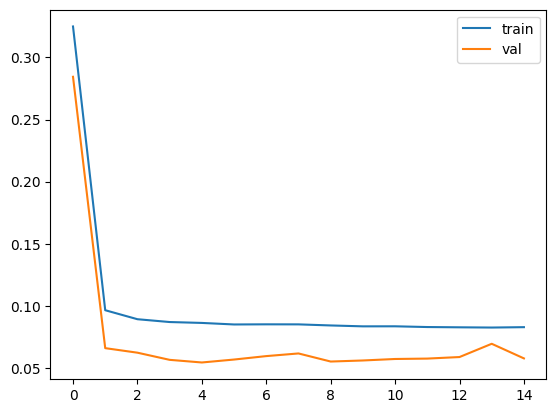

Test MSE: 0.10076975077390671
Test MAE: 0.2180503010749817
Test RMSE: 0.31744250655174255


In [101]:
train_results = task.train_model(dataset=dataset,
                                 train_rate=0.8, # Train split = 80%
                                 val_rate=0.1, # Validation split = 10%; Test split = 10%
                                 loss="mse",
                                 epochs=15,
                                 batch_size=16,
                                 device=DEVICE)